In [251]:
#import libraries
import os, re, io, tqdm

import pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

#ignore warnings
import warnings
warnings.filterwarnings(action= 'ignore')

#set parameter for "Matplotlib"
mpl.rcParams['figure.figsize'] = [16, 9]

## Data Understanting and Preperation

In [184]:
df = pd.read_csv(r'/Users/hasanzeynalov/Downloads/loan_data.csv')
df.shape

(45000, 14)

In [185]:
df['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

In [186]:
df.isnull().any().sum(), df.duplicated().sum()

(0, 0)

In [187]:
for col in df.select_dtypes(include= 'object').columns:
#     print(f"")
    print(f'{df[col].value_counts(normalize= True)}\n')

person_gender
male      0.552022
female    0.447978
Name: proportion, dtype: float64

person_education
Bachelor       0.297756
Associate      0.267289
High School    0.266044
Master         0.155111
Doctorate      0.013800
Name: proportion, dtype: float64

person_home_ownership
RENT        0.520956
MORTGAGE    0.410867
OWN         0.065578
OTHER       0.002600
Name: proportion, dtype: float64

loan_intent
EDUCATION            0.203400
MEDICAL              0.189956
VENTURE              0.173756
PERSONAL             0.167822
DEBTCONSOLIDATION    0.158778
HOMEIMPROVEMENT      0.106289
Name: proportion, dtype: float64

previous_loan_defaults_on_file
Yes    0.507956
No     0.492044
Name: proportion, dtype: float64



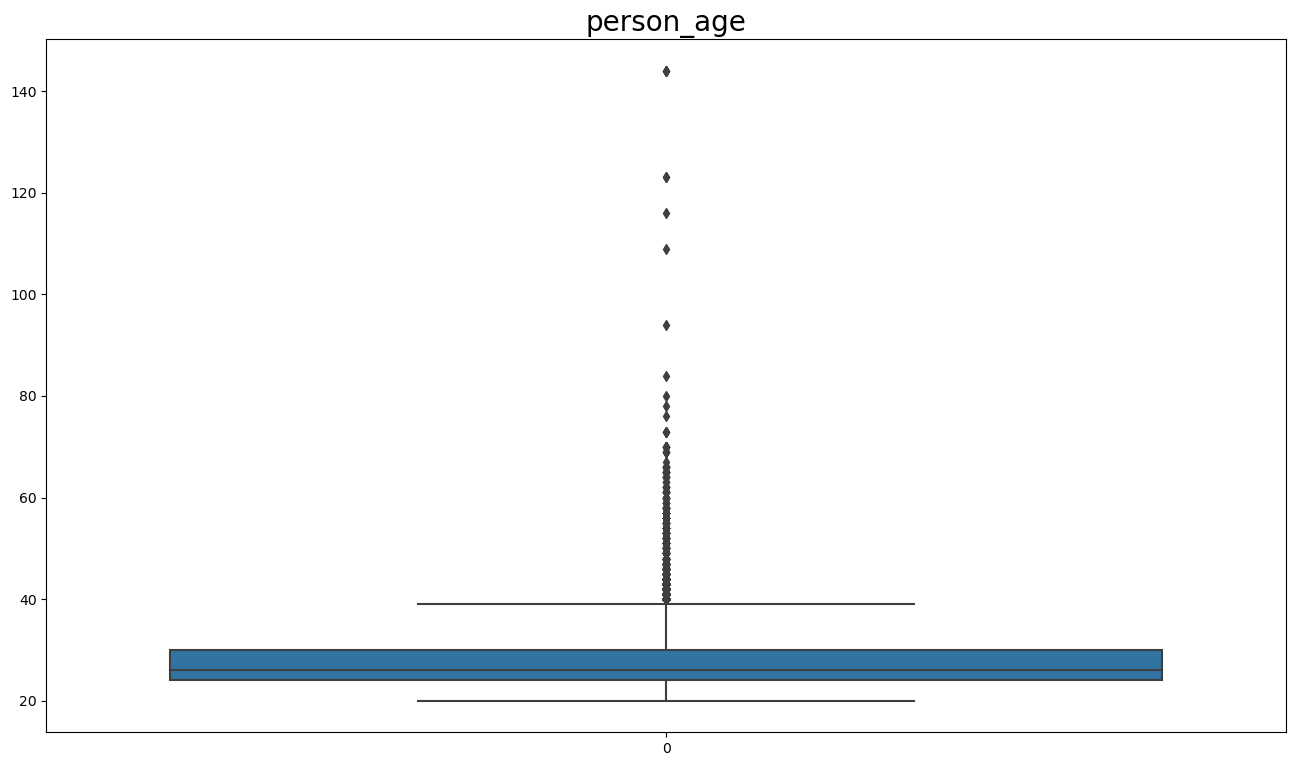

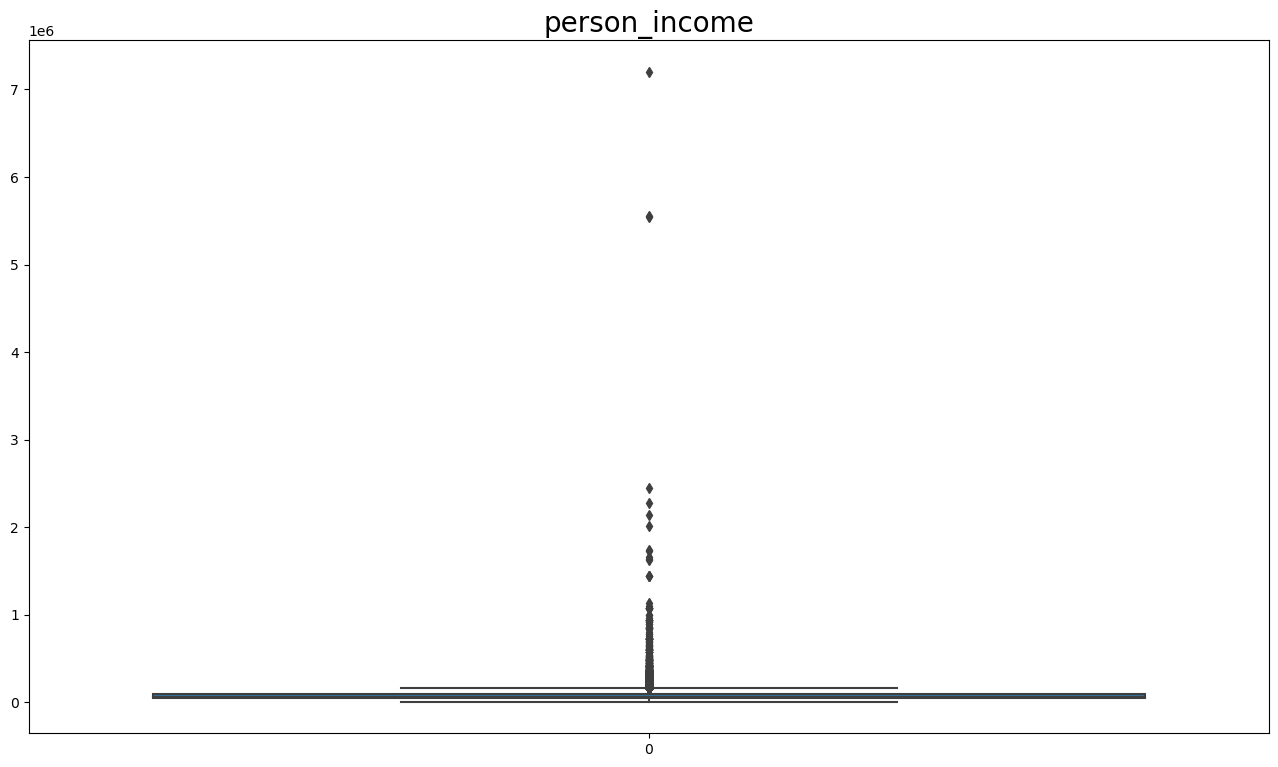

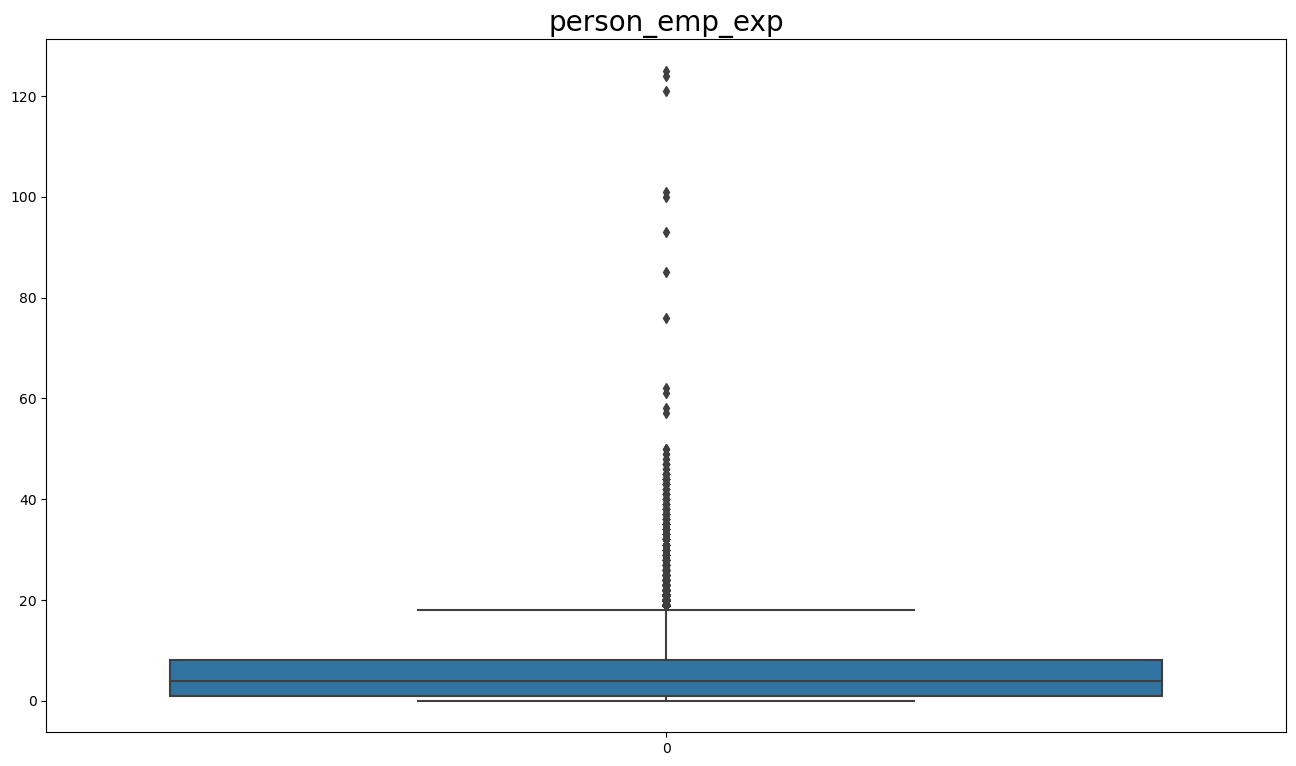

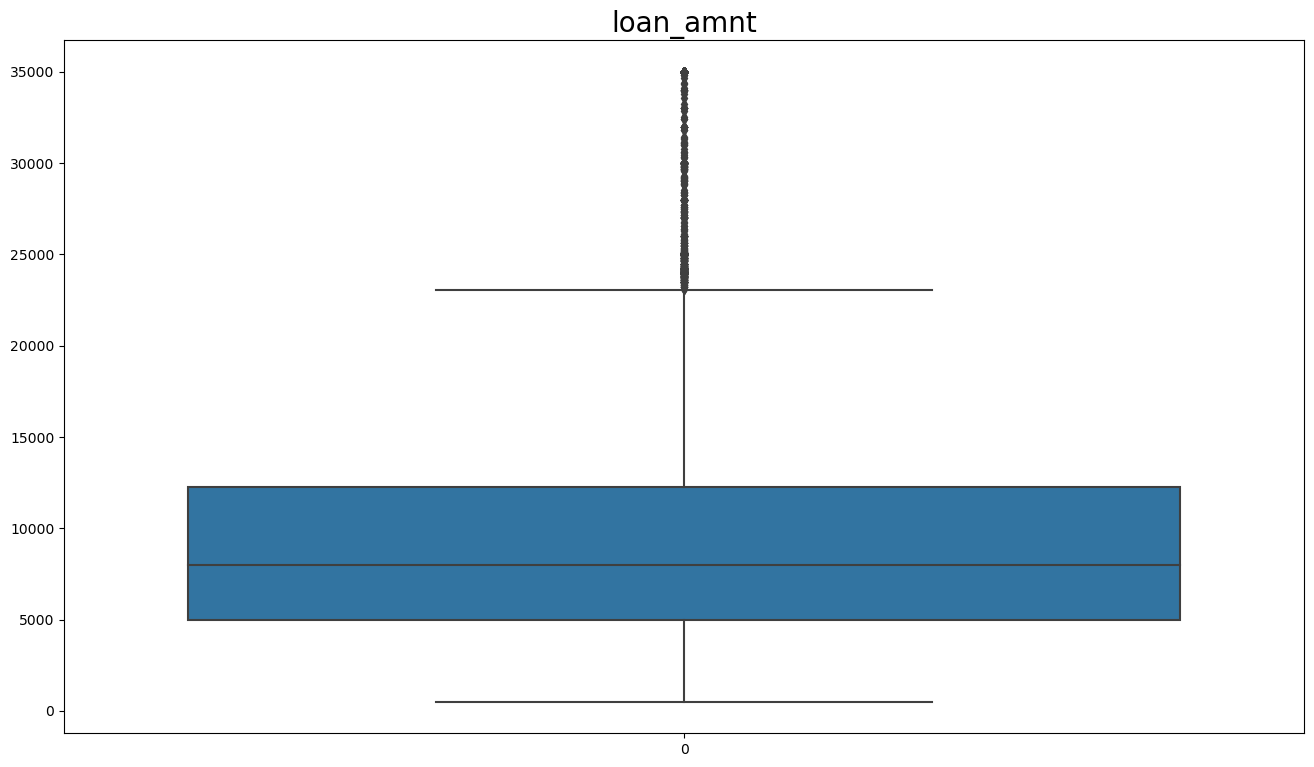

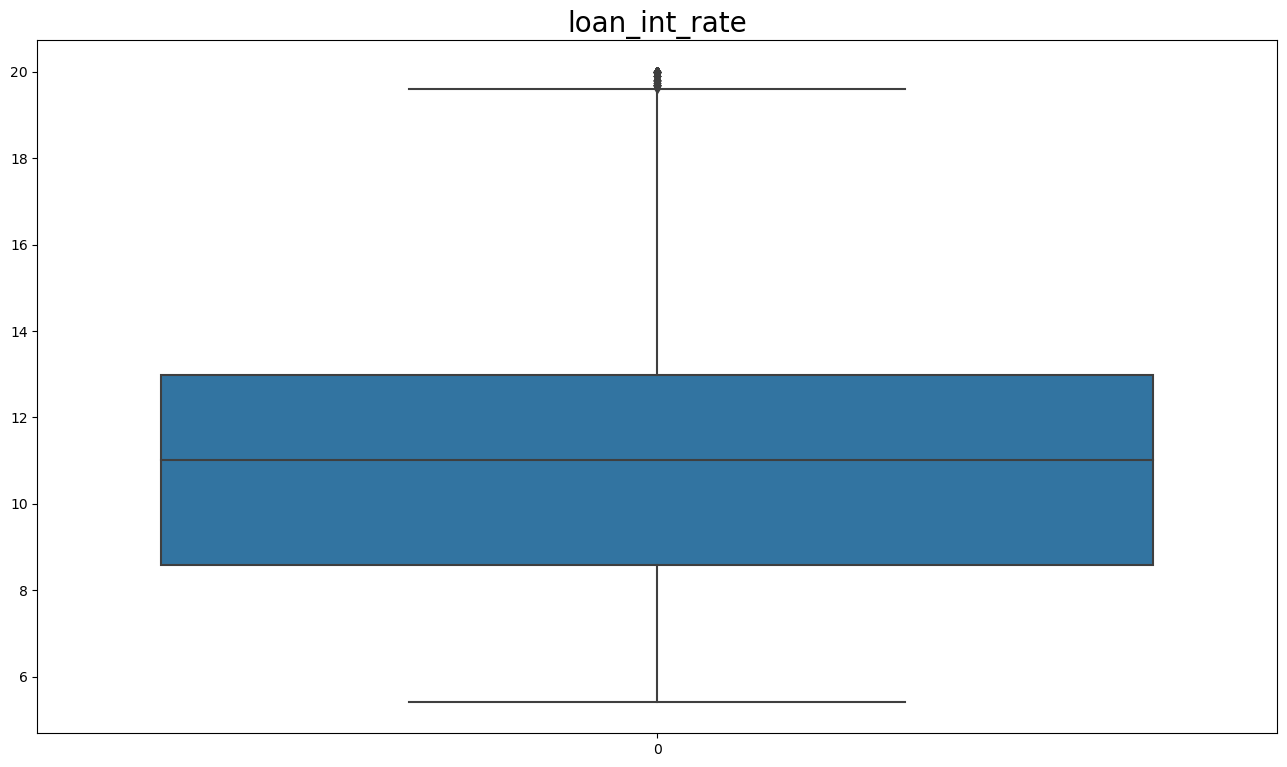

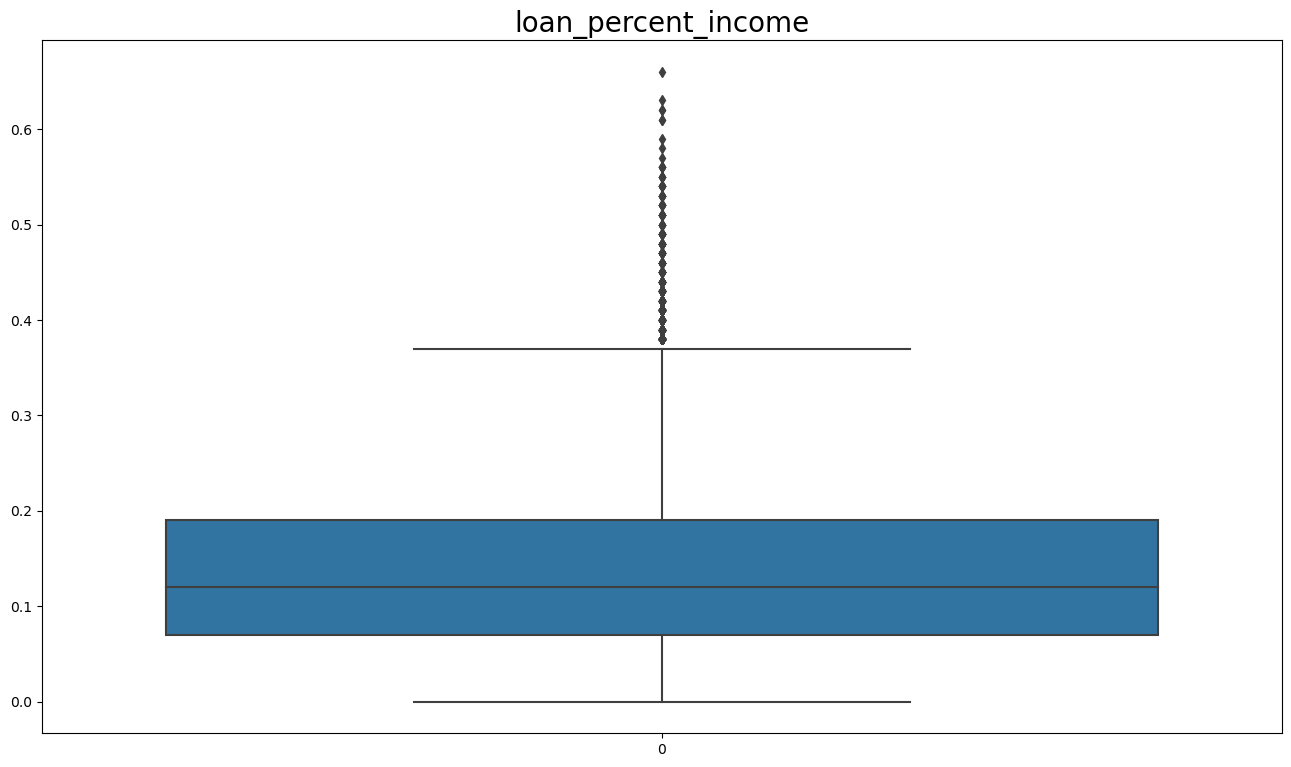

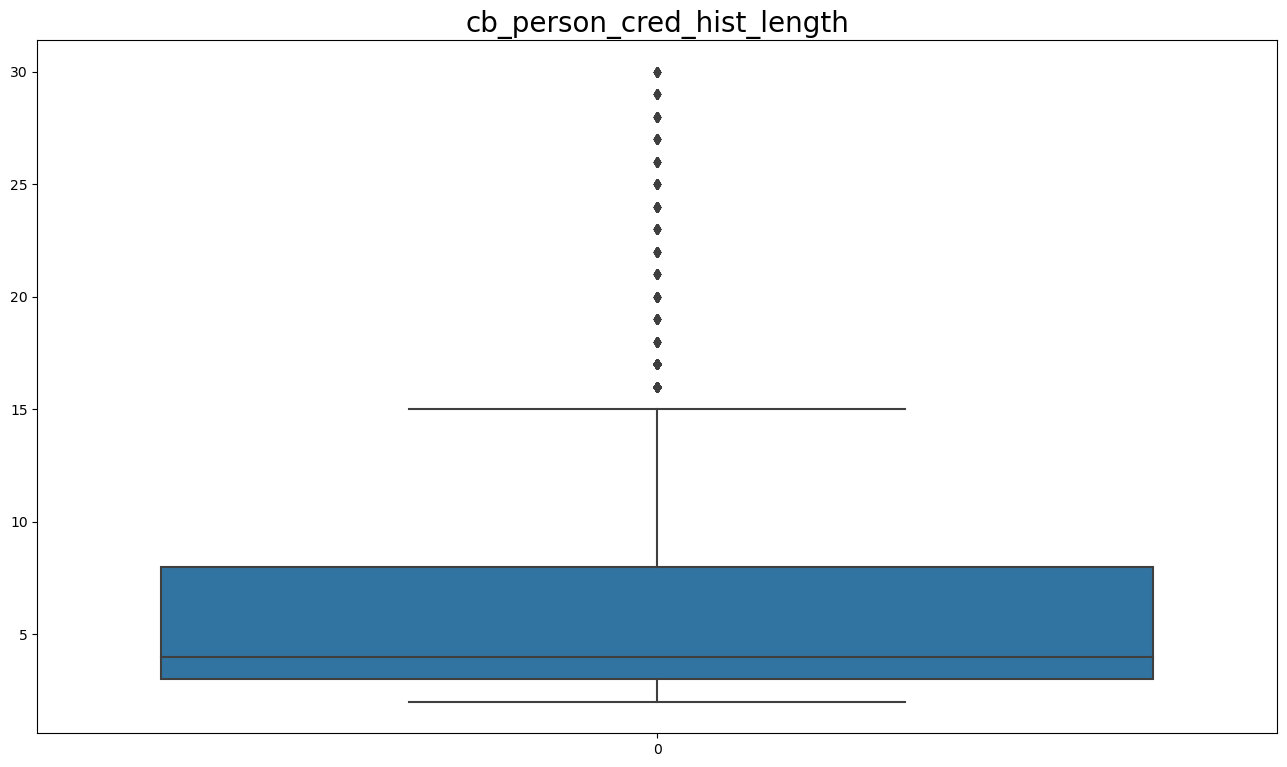

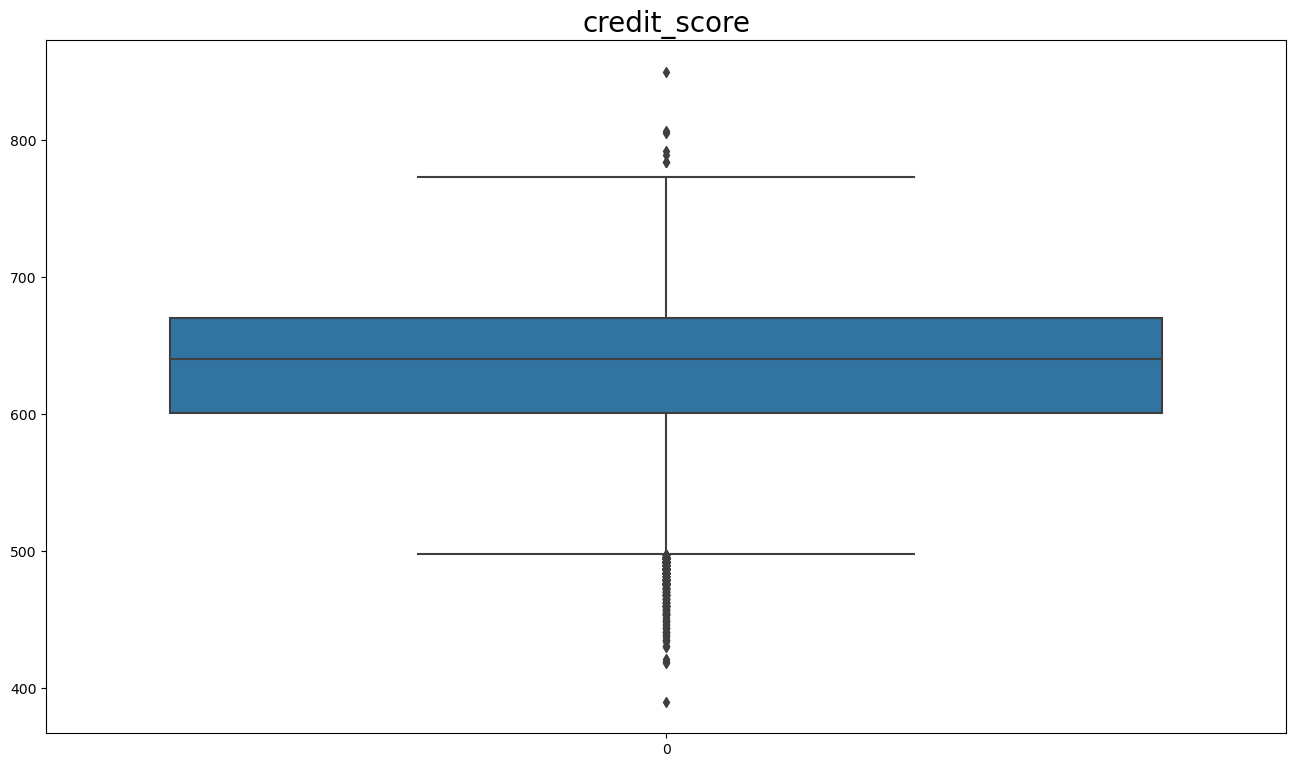

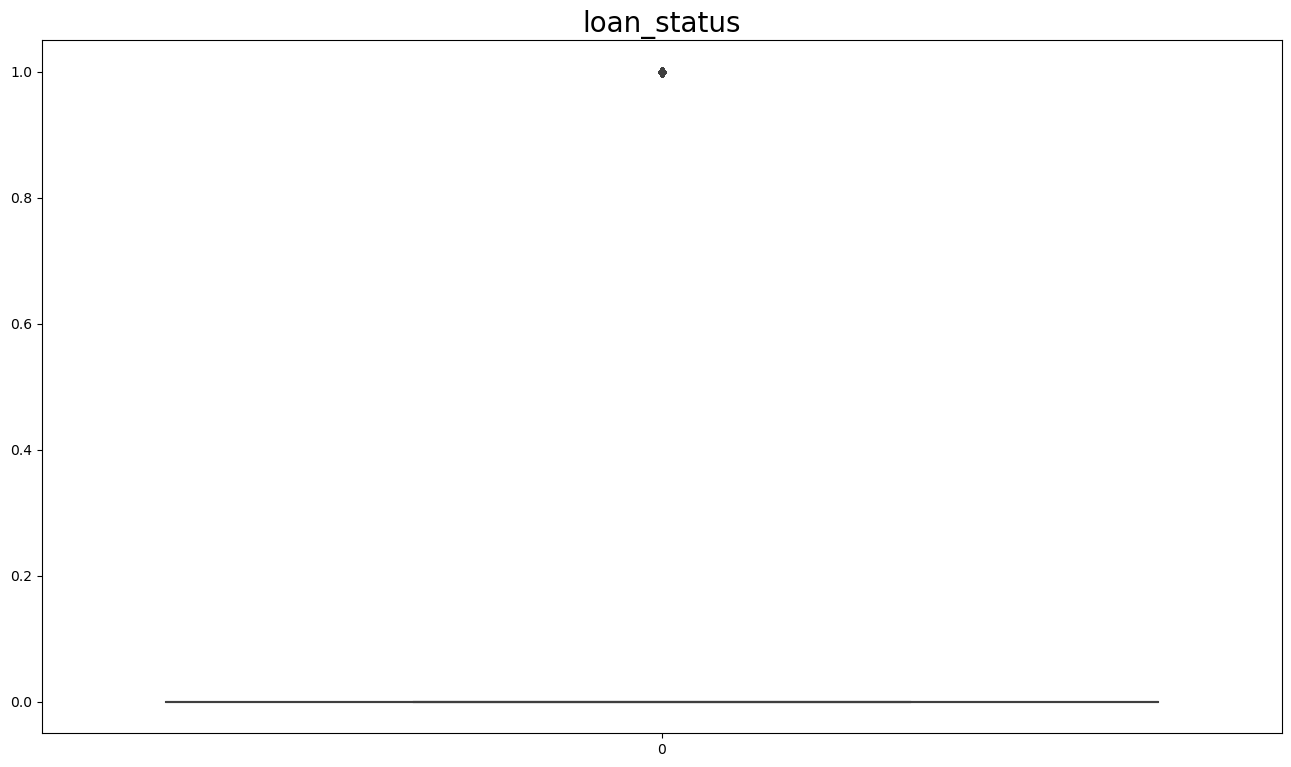

In [188]:
for col in df.select_dtypes(exclude= 'object').columns:
    sns.boxplot(df[col])
    plt.title(col, fontsize= 20)
    plt.show()

In [189]:
percentile = 0
for col in ['person_age', 'person_income', 'loan_amnt', 
            'loan_percent_income', 'cb_person_cred_hist_length']:
    if col in ['person_age', 'person_income']:
        percentile = 0.999
    else:
        percentile = 0.95
    quantile_value = np.quantile(df[col], percentile)
    df.loc[df[df[col] > quantile_value].index, col] = quantile_value
    
df.drop(['person_emp_exp'], axis= 1, inplace= True) #loan_percent_income 
df.loc[df[df['person_home_ownership'].isin(['MORTGAGE', 'OWN'])].index, 'person_home_ownership'] = 1
df.loc[df[df['person_home_ownership'].isin(['OTHER', 'RENT'])].index, 'person_home_ownership'] = 0
df.loc[df[df['person_education'].isin(['Master', 'Doctorate'])].index, 'person_education'] = 'Master_Doctorate'
df['person_home_ownership'] = df['person_home_ownership'].astype(int)
df.loc[df[df['loan_intent'].isin(['PERSONAL', 'HOMEIMPROVEMENT'])].index, 'loan_intent'] = 'Personal'
dummy_df = pd.get_dummies(df.select_dtypes(include= 'object'), drop_first= True, dtype= int)
df = pd.concat([df, dummy_df], axis= 1).drop(['person_gender', 'person_education', 'loan_intent',
                                             'previous_loan_defaults_on_file'], axis = 1)

df = df[['person_age', 'person_income','person_home_ownership', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
       'person_gender_male', 'person_education_Bachelor', 'person_education_High School',
       'person_education_Master_Doctorate', 'loan_intent_EDUCATION',
       'loan_intent_MEDICAL', 'loan_intent_Personal', 'loan_intent_VENTURE',
       'previous_loan_defaults_on_file_Yes', 'loan_status']]

In [190]:
df.dtypes

person_age                            float64
person_income                         float64
person_home_ownership                   int64
loan_amnt                             float64
loan_int_rate                         float64
loan_percent_income                   float64
cb_person_cred_hist_length            float64
credit_score                            int64
person_gender_male                      int64
person_education_Bachelor               int64
person_education_High School            int64
person_education_Master_Doctorate       int64
loan_intent_EDUCATION                   int64
loan_intent_MEDICAL                     int64
loan_intent_Personal                    int64
loan_intent_VENTURE                     int64
previous_loan_defaults_on_file_Yes      int64
loan_status                             int64
dtype: object

## Modelling

In [192]:
y = df['loan_status']
X = df.drop('loan_status', axis= 1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 23)

min_max_scl = MinMaxScaler()
X_train = min_max_scl.fit_transform(X_train)
X_test = min_max_scl.transform(X_test)

In [273]:
def evaluate_metrics(model):
    choosen_model = model.fit(X_train, y_train)
    predictions = choosen_model.predict(X_test)
    
    return predictions, {'Accuracy Score': [float(round(accuracy_score(predictions, y_test), 2))],
            'Precision Score': [round(precision_score(predictions, y_test), 2)],
            'Recall Score': [round(recall_score(predictions, y_test), 2)],
            'F1 Score': [round(f1_score(predictions, y_test), 2)]}

def confusion_matrix(model):
    
    choosen_model = model.fit(X_train, y_train)
    predictions = choosen_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    return ConfusionMatrixDisplay(confusion_matrix= cm)

In [274]:
# choosen_model = model.fit(X_train, y_train)
# predictions = choosen_model.predict(X_test)
# cm = confusion_matrix(np.array(y_test), predictions)

## 1. Logistic Regression

In [275]:
model = LogisticRegression()
linear_reg_predictions, lin_model_evaluate_scores = evaluate_metrics(model)

lin_model_evaluate_scores

{'Accuracy Score': [0.89],
 'Precision Score': [0.73],
 'Recall Score': [0.77],
 'F1 Score': [0.75]}

## 2. KNN Classfier

In [276]:
for k_neighbor in range(3, 7):
    model = KNeighborsClassifier(n_neighbors= k_neighbor)
    knn_model_predictions, knn_model_evaluate_scores = evaluate_metrics(model)
    print(f'Neighbors: {k_neighbor} ------>>>> {knn_model_evaluate_scores}')

Neighbors: 3 ------>>>> {'Accuracy Score': [0.88], 'Precision Score': [0.68], 'Recall Score': [0.78], 'F1 Score': [0.72]}
Neighbors: 4 ------>>>> {'Accuracy Score': [0.89], 'Precision Score': [0.59], 'Recall Score': [0.85], 'F1 Score': [0.69]}
Neighbors: 5 ------>>>> {'Accuracy Score': [0.89], 'Precision Score': [0.67], 'Recall Score': [0.79], 'F1 Score': [0.73]}
Neighbors: 6 ------>>>> {'Accuracy Score': [0.89], 'Precision Score': [0.61], 'Recall Score': [0.85], 'F1 Score': [0.71]}


In [277]:
model = KNeighborsClassifier(n_neighbors= 5)
knn_model_predictions, knn_model_evaluate_scores = evaluate_metrics(model)
knn_model_evaluate_scores

{'Accuracy Score': [0.89],
 'Precision Score': [0.67],
 'Recall Score': [0.79],
 'F1 Score': [0.73]}

## 3. Decision Tree Classifier


In [278]:
model = DecisionTreeClassifier()
decision_tree_predictions, decision_tree_evaluate_scores = evaluate_metrics(model)
decision_tree_evaluate_scores

{'Accuracy Score': [0.9],
 'Precision Score': [0.76],
 'Recall Score': [0.77],
 'F1 Score': [0.77]}

## 4. Random Forest Classifier


In [279]:
model = RandomForestClassifier()
random_forest_model_predictions, random_forest_model_evaluate_scores = evaluate_metrics(model)
random_forest_model_evaluate_scores

{'Accuracy Score': [0.92],
 'Precision Score': [0.75],
 'Recall Score': [0.89],
 'F1 Score': [0.81]}

## 5. XGBoost Classifier

In [280]:
model = XGBClassifier()
xg_boost_predictions, xg_boost_model_evaluate_scores = evaluate_metrics(model)
xg_boost_model_evaluate_scores

{'Accuracy Score': [0.93],
 'Precision Score': [0.79],
 'Recall Score': [0.89],
 'F1 Score': [0.83]}

## Hyperparameter Tuning

In [253]:
model = RandomForestClassifier()

parameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15],
    'min_samples_leaf' : [1, 3, 5]
}

grid_search_cv = GridSearchCV(estimator= model, 
                              param_grid= parameters,
                              cv= 10) #mumkun butun parameterleri yoxluyur

#RandomizedSearchCV - sizin teyin etdiyiniz random sayda parameter combinasiyini yoxluyur

grid_search_cv.fit(X, y)

In [254]:
model = RandomForestClassifier()

parameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15],
    'min_samples_leaf' : [1, 3, 5]
    
}


grid_search_cv = RandomizedSearchCV(estimator= model, 
                                    param_grid= parameters,
                                    cv= 10,
                                    n_iter= 25) #25 dene random combinasiya yoxluyur


#RandomizedSearchCV - sizin teyin etdiyiniz random sayda parameter combinasiyini yoxluyur

grid_search_cv.fit(X, y)

## Finalize Model Results

In [286]:
final_results = pd.concat([pd.DataFrame(lin_model_evaluate_scores, index= ['Logistic Regression']),
                           pd.DataFrame(decision_tree_evaluate_scores, index= ['Decision Tree']),
                           pd.DataFrame(random_forest_model_evaluate_scores, index= ['Random Forest']),
                           pd.DataFrame(knn_model_evaluate_scores, index= ['KNN Model']),
                           pd.DataFrame(xg_boost_model_evaluate_scores, index= ['XGBoost'])])

In [289]:
final_results.sort_values(by= 'Accuracy Score', ascending= False)

,Accuracy Score,Precision Score,Recall Score,F1 Score
XGBoost,0.93,0.79,0.89,0.83
Random Forest,0.92,0.75,0.89,0.81
Decision Tree,0.90,0.76,0.77,0.77
Logistic Regression,0.89,0.73,0.77,0.75
KNN Model,0.89,0.67,0.79,0.73
